In [430]:
import os
import json
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.nn.functional import one_hot

/tmp/ipykernel_57139/3885768995.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [431]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [432]:
transform = v2.Compose(
    [
     v2.ToTensor(),
     v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = ImageFolder('./trafic_32', transform=transform)
train_classes = train_data.classes
train_classes = [name.lstrip('0') if name != '00000' else '0' for name in train_classes]
train_classes

/home/michal/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42']

In [433]:
train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [434]:
data, classes = next(iter(train_loader))
data.size()

torch.Size([256, 3, 32, 32])

## VAE

In [435]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [436]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

In [437]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim + 43, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        z = torch.rand(1).to(device) * var + mean
        return z


    def forward(self, x, one_hot_class):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        z = torch.concat((z, one_hot_class), dim=1)

        x_hat = self.decoder(z)
        return x_hat, mean, log_var

## Training

In [438]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=3072).to(device)

In [439]:
encoding = one_hot(torch.arange(0, 43), 43)
encoding.size()
encoding[34].size()

torch.Size([43])

In [440]:
def get_classes_encoded(train_classes: list, classes_names: list, encoding):
    # index = train_classes.index(class_name)
    return torch.stack([encoding[train_classes.index(str(name.item()))] for name in classes_names], dim=0)

In [441]:
# c1 = get_classes_encoded(train_classes, torch.tensor([4, 34, 3, 0]), encoding)
# c2 = get_classes_encoded(train_classes, torch.tensor([4, 34, 3, 0]), encoding)
# c3 = torch.concat((c1, c2), dim=1)
# c3

In [442]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [443]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [445]:
epochs_losses = []
num_epochs = 200
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        # x = x.to(device)

        classes_encoded = get_classes_encoded(train_classes, _, encoding)
        out, means, log_var = vae(x, classes_encoded)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    L1_list = []
#     if n % 10 == 0:
    # for x, _ in iter(test_loader):
    #     x  = x.to(device)
    #     out, _, _ = vae(x)

    #     L1_list.append(torch.mean(torch.abs(out-x)).item())
    epochs_losses.append(np.mean(np.array(losses_epoch)))
    print(f"Epoch {n} loss {epochs_losses[-1]}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 301055.0618872549, test L1 = nan
Epoch 1 loss 300769.33986928104, test L1 = nan
Epoch 2 loss 300589.5402369281, test L1 = nan
Epoch 3 loss 300319.8214869281, test L1 = nan
Epoch 4 loss 300267.64338235295, test L1 = nan
Epoch 5 loss 300066.59722222225, test L1 = nan
Epoch 6 loss 300046.0919117647, test L1 = nan
Epoch 7 loss 299799.05923202616, test L1 = nan
Epoch 8 loss 299517.80004084966, test L1 = nan
Epoch 9 loss 299414.30555555556, test L1 = nan
Epoch 10 loss 299237.07659313723, test L1 = nan
Epoch 11 loss 299135.6544117647, test L1 = nan
Epoch 12 loss 299062.2632761438, test L1 = nan
Epoch 13 loss 299001.141748366, test L1 = nan
Epoch 14 loss 298732.3282271242, test L1 = nan
Epoch 15 loss 298713.8445669935, test L1 = nan
Epoch 16 loss 298682.3868464052, test L1 = nan
Epoch 17 loss 298652.6815767974, test L1 = nan
Epoch 18 loss 298451.810253268, test L1 = nan
Epoch 19 loss 298307.92279411765, test L1 = nan
Epoch 20 loss 298371.9501633987, test L1 = nan
Epoch 21 loss 298

KeyboardInterrupt: 

In [468]:
def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(10,10+num)], dim=0)

In [469]:
input_imgs = get_train_images(8)

In [460]:
small_encoding = encoding[:8]
rmd_to_generate = torch.randn([8, vae.latent_dim])
rmd_to_generate.size()
classes_to_generate = torch.concat((rmd_to_generate, encoding[:8]), dim=1)
classes_to_generate

tensor([[-0.9524, -1.2620,  0.3436, -0.3776, -2.1400,  0.3492,  0.5938,  0.8890,
         -1.4948,  2.4889,  0.7540,  2.0463,  0.4341, -0.3593,  0.5086,  0.3300,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 1.2872, -0.4974, -1.4394,  0.7713, -0.6861,  2.2886, -0.7337, -0.1449,
         -0.9729,  0.6943,  0.8299,  0.1971,  0.8971, -1.4543, -0.7139,  0.0708,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

In [487]:


def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    rmd_to_genrate = torch.randn([8, model.latent_dim])
    classes_to_generate = torch.concat((rmd_to_genrate, encoding[:8]), dim=1)
    with torch.no_grad():
        generated_imgs = model.decoder(classes_to_generate).to(device)
    generated_imgs = generated_imgs.cpu()


    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

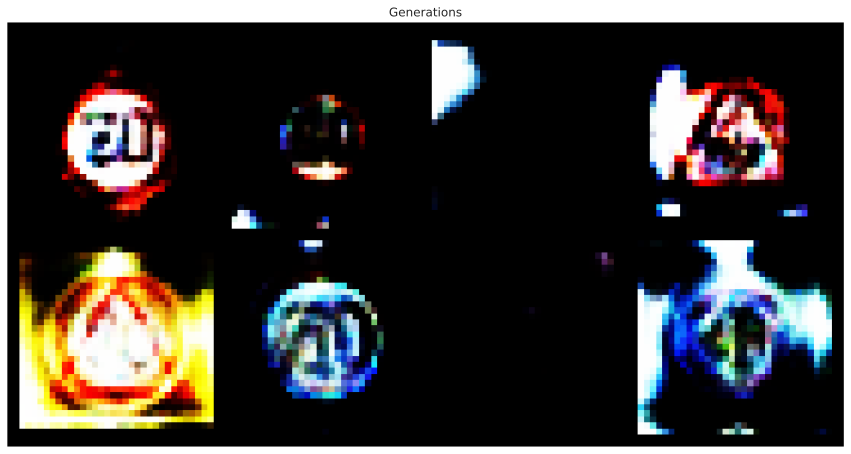

In [504]:
generate_images(vae, 10, device)